# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction: Business Problem</a>

2. <a href="#item2">Data</a>

3. <a href="#item3">Methodology</a>

4. <a href="#item4">Analysis</a>

5. <a href="#item5">Results and Discussion</a>

6. <a href="#item6">Conclusion</a>

</font>
</div>

## 1. Introduction: Business Problem <a href="#item1"></a>

The goal of the project is to determine an acceptable location for the opening of an Italian restaurant within a radius of **2 kilometers** from the center **of Tverskaya Street, Moscow.**

The criterion for determining eligibility will be the **minimum number** of similar restaurants.  

## 2. Data <a href="#item2"></a>

Based on the definition of our problem, to achieve the goal we need the following data:
* coordinates of the center of Tverskaya street.
* number of existing Italian restaurants in the area 2 kilometers from the center of the Tverskaya street.

Following data sources will be needed to extract/generate the required information:
* to get the coordinates we will be utilize **geopy** library.
* number of Italian restaurants will be obtained using **Foursquare API**

First of all we import necessary libraries

In [1]:
!pip install geopy
import geopy
import folium

import requests

import json

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print("Libraries successfully imported")

     |████████████████████████████████| 112kB 15.4MB/s eta 0:00:01
Libraries successfully imported


### Find Tverskaya Street Coordinates

In [2]:
locator = geopy.Nominatim(user_agent="myMap")
location = locator.geocode("Tverskaya, Moscow, Russia")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of the center of Tverskaya street is: \n - Latitude = {location.latitude}, \n - Longitude = {location.longitude}")

Coordinates of the center of Tverskaya street is: 
 - Latitude = 55.7648759, 
 - Longitude = 37.6062783


### Foursquare

When we have a street coordinates we will get data of all Italian restaurants in 2 km radius.

In [3]:
# Set credentials
CLIENT_ID = 'FJV5ILBCCU4MYGEJXN0DES4BLH20LO5054SN2OVZ3MLBVQZA'
CLIENT_SECRET = 'OAKPQMD0YBXOHGQWATGE045MTNZDJ2AUBH2ACSBDPL4TN2AL'
VERSION = '20180605'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
category = "4bf58dd8d48988d110941735" # categoryID of Italian restaurants
url = 'https://api.foursquare.com/v2/venues/explore'
LL = f"{location.latitude}, {location.longitude}" # coordinates of Tverskaya

params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v=VERSION,
    ll=LL,
    categoryId=category,
    limit=LIMIT,
    radius=radius,
)

request = requests.get(url=url, params=params)
result = json.loads(request.text)
result

{'meta': {'code': 200, 'requestId': '5e5d2971bae9a2001bb0b8b6'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Tverskoy',
  'headerFullLocation': 'Tverskoy, Moscow',
  'headerLocationGranularity': 'neighborhood',
  'query': 'italian',
  'totalResults': 96,
  'suggestedBounds': {'ne': {'lat': 55.782875918000016,
    'lng': 37.63821345771256},
   'sw': {'lat': 55.74687588199998, 'lng': 37.57434314228744}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5b295f936336be002dab0dcc',
       'name': 'Иностранцы',
       'location': {'address': 'Тверской бул., 24',
        'lat': 55.762315719779835,
        'lng': 37.60352849799727,
        'labeledLatLngs': [{'label': 'display',
       

### Create a Pandas Dataframe of Italian Restaurants

Write a function that takes name, category, longitude and latitude of restaurant 

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Use the function for each restaurant and convert it to pandas Dataframe

In [5]:
restaurant = result['response']['groups'][0]['items']
    
it_restaurant = json_normalize(restaurant) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
it_restaurant = it_restaurant.loc[:, filtered_columns]

# filter the category for each row
it_restaurant['venue.categories'] = it_restaurant.apply(get_category_type, axis=1)

# clean columns
it_restaurant.columns = [col.split(".")[-1] for col in it_restaurant.columns]

it_restaurant.rename(columns={"name": "Name", "categories": "Category", "lat": "Latitude", "lng": "Longitude"}, inplace=True)

it_restaurant.head()

,Name,Category,Latitude,Longitude
0,Иностранцы,Italian Restaurant,55.762316,37.603528
1,Bocconcino,Italian Restaurant,55.767234,37.608281
2,Венеция,Italian Restaurant,55.765332,37.608115
3,Probka,Italian Restaurant,55.768905,37.623109
4,Венеция,Italian Restaurant,55.763305,37.614826


In [6]:
print('{} restaurants were returned by Foursquare.'.format(it_restaurant.shape[0]))

96 restaurants were returned by Foursquare.


Let's how it's look like on the map

In [7]:
map_tverskaya = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(it_restaurant['Latitude'], it_restaurant['Longitude'], it_restaurant['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tverskaya)  
    
map_tverskaya

## 3. Methodology <a href="#item3"></a>

In this project we will direct our efforts on detecting areas that have low restaurant density, particularly those with low number of Italian restaurants. We will limit our analysis to area 2 km around Tverskaya Street.

In first step we have collected the required **data: location of every restaurant within 2 km from Moscow center**.

Second step in our analysis will be calculation and exploration of **restaurant density** across different areas of Tverskaya Street. We will create clusters (using **k-means clustering**) to identify those locations which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## 4. Analysis <a href="#item4"></a>

### Create k-means model

In [8]:
tverskaya_grouped_clustering = it_restaurant.drop(['Category', 'Name'], 1)

Determine the optimal number of clusters

In [9]:
Ks = 10 # number of ks we will test
inertias = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0, n_init = 12).fit(tverskaya_grouped_clustering)
    inertias[n-1] = kmeans.inertia_

# display the inertia    
inertias

array([0.02540626, 0.0104951 , 0.00742371, 0.00569026, 0.0043219 ,
       0.00346235, 0.00280651, 0.00237753, 0.00207759])

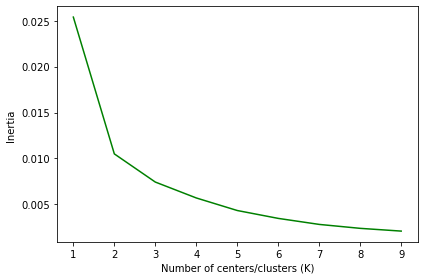

In [10]:
plt.plot(range(1,Ks),inertias,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

Now we see that the 5 cluster will be the optimal number of clusters

Run *k*-means to cluster the restaurants into 5 clusters.

In [11]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tverskaya_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 4, 0, 1, 0, 0, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [12]:
# add clustering labels
it_restaurant.insert(0, 'Cluster Labels', kmeans.labels_)
it_restaurant.head()

,Cluster Labels,Name,Category,Latitude,Longitude
0,1,Иностранцы,Italian Restaurant,55.762316,37.603528
1,0,Bocconcino,Italian Restaurant,55.767234,37.608281
2,0,Венеция,Italian Restaurant,55.765332,37.608115
3,4,Probka,Italian Restaurant,55.768905,37.623109
4,0,Венеция,Italian Restaurant,55.763305,37.614826


Let's compare the size 

In [13]:
it_restaurant.shape

(96, 5)

Now we’ll build a map to see how the restaurants are distributed among the clusters

In [14]:
map_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, label, cluster in zip(it_restaurant['Latitude'], it_restaurant['Longitude'], it_restaurant['Name'], it_restaurant["Cluster Labels"]):
    label = folium.Popup(str(label) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster) 
    
map_cluster

Then count how much restaurants in each cluster

In [15]:
it_restaurant['Cluster Labels'].value_counts()

1    24
0    21
2    19
3    17
4    15
Name: Cluster Labels, dtype: int64

Least of all Italian restaurants was in cluster number 4

Let's see coordinates of a centroid for each cluster 

In [112]:
i = 0
for cluster in kmeans.cluster_centers_:
    print(f"The center of cluster # {i} is {cluster}")  
    i += 1

The center of cluster # 0 is [55.75929493 37.61443998]
The center of cluster # 1 is [55.77523202 37.59279093]
The center of cluster # 2 is [55.77192192 37.61925421]
The center of cluster # 3 is [55.759778   37.59576783]
The center of cluster # 4 is [55.76243123 37.62989919]


Let's see what streets are at given coordinates

In [25]:
geolocator = geopy.Nominatim(user_agent="myMap")
for cluster in kmeans.cluster_centers_:
    location = geolocator.reverse(cluster)
    print(location.address)

Московский художественный театр им. А. П. Чехова, 3 с1, Камергерский переулок, 58, Тверской район, Центральный административный округ, Москва, Центральный федеральный округ, 125009, Россия
13, Малая Бронная улица, 48, Старое Ваганьково, Москва, Центральный административный округ, Москва, Центральный федеральный округ, 119049, Россия
1, улица Александра Невского, 49, Сущёво, Тверской район, Центральный административный округ, Москва, Центральный федеральный округ, 125047, Россия
Федеральная служба безопасности Российской Федерации, Фуркасовский переулок, Мещанский район, Центральный административный округ, Москва, Центральный федеральный округ, 101000, Россия
21 с9, Цветной бульвар, Мещанский район, Центральный административный округ, Москва, Центральный федеральный округ, 127051, Россия


## 5. Results and Discussion <a href="#item5"></a>

According to the results of the analysis, it was found that a fairly large number of restaurants are located within a radius of 2 kilometers from the center of Tverskaya Street. Restaurants are evenly distributed, while a lower density of Italian restaurants is recorded in the northeast of the center of the street. Thus, the smallest total of restaurants of the indicated subjects are located in cluster No. 4, the center of which is Tsvetnoy Boulevard 21.

In connection with the above, I would recommend opening an Italian restaurant in the area of Tsvetnoy Boulevard 21.

In addition, it should be noted that cluster No. 3 also recorded a small density of Italian restaurants, in our opinion, it is also acceptable to establish a restaurant in the area of the center of this cluster.

## 6. Conclusion <a href="#item6"></a>

Purpose of this project was to identify Moscow areas close to center with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first and then generated extensive collection of locations existing restaurants. Clustering of those locations was then performed in order to create major zones of interest and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.